# Trabalho 2

* Aluno : Gabriel Borin Macedo
* RA : 197201

## Descrição do trabalho

## Parte 0 : criação de função úteis para o programa

Inicialmente, será definido algumas funções úteis para este _notebook_

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

from glob import glob
from skimage.measure import label, regionprops_table


def read_images(images_path: list[str]) -> tuple[list, list]:
    """
    Função que realiza a leitura de imagens no diretório e retorna uma tupla de lista que contém
    respectivamente as imagens monocromáticas e no padrão RGB

    Args:
        images_path (list[str]): lista de strings que contém o caminho para leitura de todas as imagens

    Notes:
        esse código foi baseado neste (https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html#:~:text=The%20conversion%20from%20a%20RGB,done%20with%20cv%3A%3AmixChannels.)

    Returns (tuple[list, list]):
        retorna uma tupla que contém respectivamente as imagens monocromáticas e no padrão RGB

    """

    gray_images_vec = []
    rgb_images_vec = []

    for img_path in images_path:
        print("Lendo a imagem de nome {}".format(img_path))

        # Estamos lendo a imagem em BGR e depois convertendo para RGB
        img_rgb = cv2.imread(img_path)[..., ::-1]

        # Fazendo a conversão de RGB para escala de cinza
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

        gray_images_vec.append(img_gray)
        rgb_images_vec.append(img_rgb)

    return gray_images_vec, rgb_images_vec


def plot_figures_in_line(first_img: np.ndarray, second_img: np.ndarray, title1: str = "",
                         title2: str = "", **kwargs: dict) -> None:
    """
    Função que realiza a plotagem de duas imagens na horizontal. Mais precisamente, a imagem colorida é apresentado mais à esquerda
    enquanto que a imagem monocromática é apresentada na direita

    Args:
        first_img (np.ndarray): um vetor que representa a imagem na escala rgb
        second_img (np.ndarray): um vetor que representa a imagem na escala de cinza
        title1 (str): string que representa o título da imagem rgb
        title2 (str): string que representa o título da imagem monocromática
        **kwargs (dict): dicionário que contém os parâmetros de salvar a imagem, o tamanho da figura e se o png será salvo como uma figura transparente

    Returns (None):

    """

    if "save_fig" in kwargs.keys():
        save_fig_name = kwargs.pop("save_fig")
        save_dir = kwargs.pop("save_dir")

    else:
        save_fig_name = ""
        save_dir = ""

    if "figsize" in kwargs.keys():
        figsize_val = kwargs.pop("figsize")

    else:
        figsize_val = (15, 15)

    if "fontsize_title" in kwargs.keys():
        fontsize_title = kwargs.pop("fontsize_title")

    else:
        fontsize_title = 20

    if "first_cmap" in kwargs.keys():
        first_cmap = kwargs.pop("first_cmap")

    else:
        first_cmap = None

    if "second_cmap" in kwargs.keys():
        second_cmap = kwargs.pop("second_cmap")

    else:
        second_cmap = None

    fig, ax = plt.subplots(1, 2, figsize=figsize_val)

    # Plot da imagem rgb

    if first_img is not None:
        ax[0].imshow(first_img, cmap=first_cmap, vmin=first_img.min(), vmax=first_img.max())

    else:
        ax[0].imshow(first_img, vmin=first_img.min(), vmax=first_img.max())

    ax[0].set_title(title1, fontsize=fontsize_title)

    # Plot da imagem em tom de cinza
    if second_cmap is not None:
        ax[1].imshow(second_img, cmap=second_cmap, vmin=second_img.min(), vmax=second_img.max())

    else:
        ax[1].imshow(second_img, vmin=second_img.min(), vmax=second_img.max())

    ax[1].set_title(title2, fontsize=fontsize_title)

    for a in ax:
        a.axis('off')
    if save_fig_name:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_dir + save_fig_name)

    plt.show()


def extract_image_info(image: np.ndarray) -> tuple[pd.DataFrame, np.ndarray]:
    """
    Função que extrai as informações de área, perimetro, ecentricidade e solidez dos objetos de uma imagem e retorna
    um pandas dataframe que contém estas informações

    Args:
        image (np.ndarray): imagem de entrada

    Returns (pd.DataFrame):
        retorna um dataframe que contém as informações de área, perimetro, ecentricidade e solidez dos objetos de uma imagem.

    """

    label_img = label(image) - 1
    print("label_img max : {}".format(label_img.max()))
    props = regionprops_table(label_img, properties=("area",
                                                     "perimeter",
                                                     "eccentricity",
                                                     "solidity",
                                                     "centroid",
                                                     "moments"))
    df = pd.DataFrame(props)
    return df, label_img

## Parte 1 : Conversão de imagens no tom de cinza para a escala monocromática

[#TODO] : Preciso escrever a parte teórica deste tópico. Eu deixei _linkado_ na parte da leitura de imagens uma doc de examplo para conversão de rgb para escala monocromática

### Leitura do caminho das imagens

Inicialmente, será definido o caminho para a leitura das imagens utilizando a biblioteca _glob_

In [2]:
image_files_path = sorted(glob("Imagens/*"))
gray_images, rgb_images = read_images(image_files_path)

Lendo a imagem de nome Imagens/objetos1.png
Lendo a imagem de nome Imagens/objetos2.png
Lendo a imagem de nome Imagens/objetos3.png


libpng warning: iCCP: profile 'default_rgb.icc': 0h: PCS illuminant is not D50
libpng warning: iCCP: profile 'default_rgb.icc': 0h: PCS illuminant is not D50


### Função para leitura e plotagem das imagens

Agora,será feito uma célula que pega as imagens rgb e em escala de cinza e realiza o _plot_ das imagens

Nome da imagem de entrada : objetos1
Dimensão da imagem monocromática : (327, 563)
Dimensão da imagem rgb : (327, 563, 3)


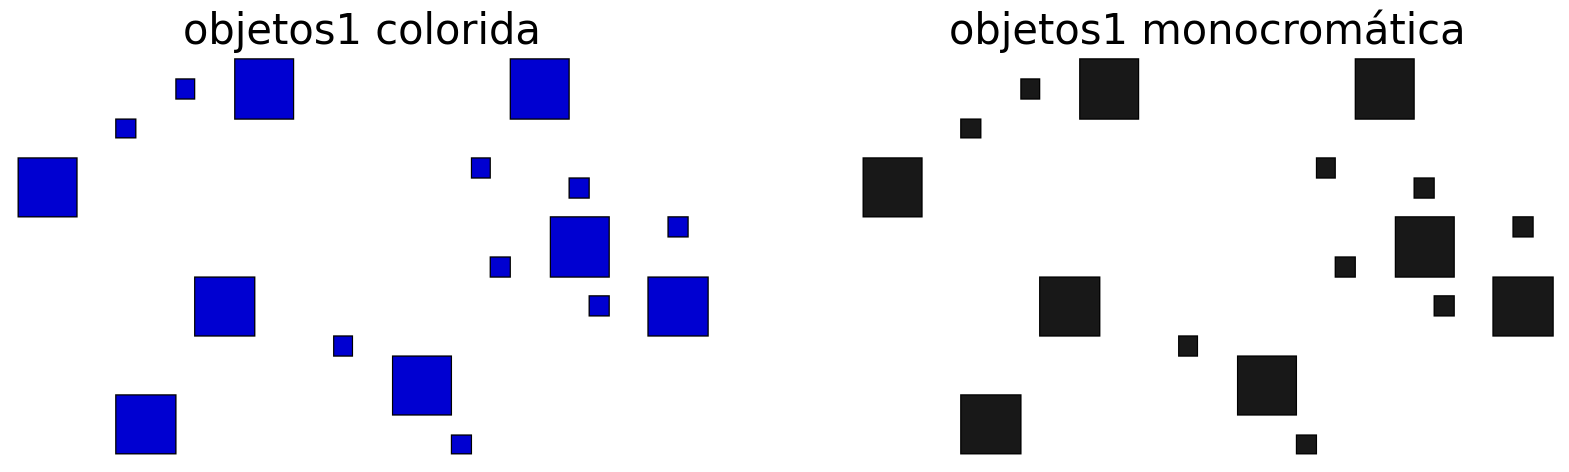

Nome da imagem de entrada : objetos2
Dimensão da imagem monocromática : (343, 563)
Dimensão da imagem rgb : (343, 563, 3)


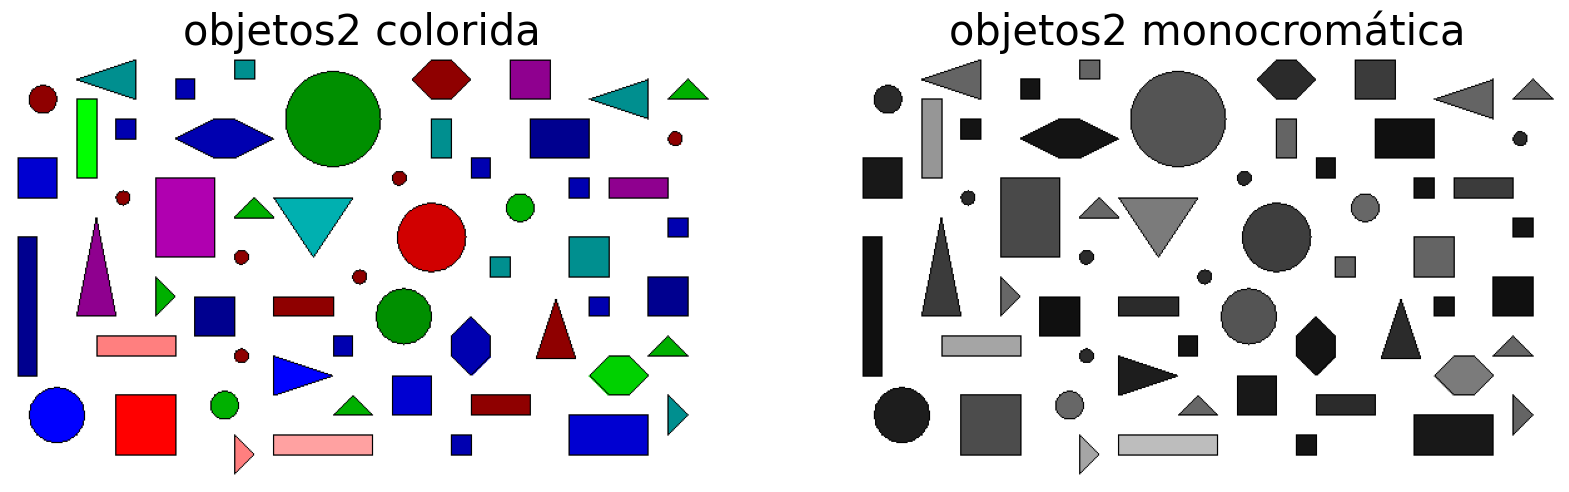

Nome da imagem de entrada : objetos3
Dimensão da imagem monocromática : (238, 238)
Dimensão da imagem rgb : (238, 238, 3)


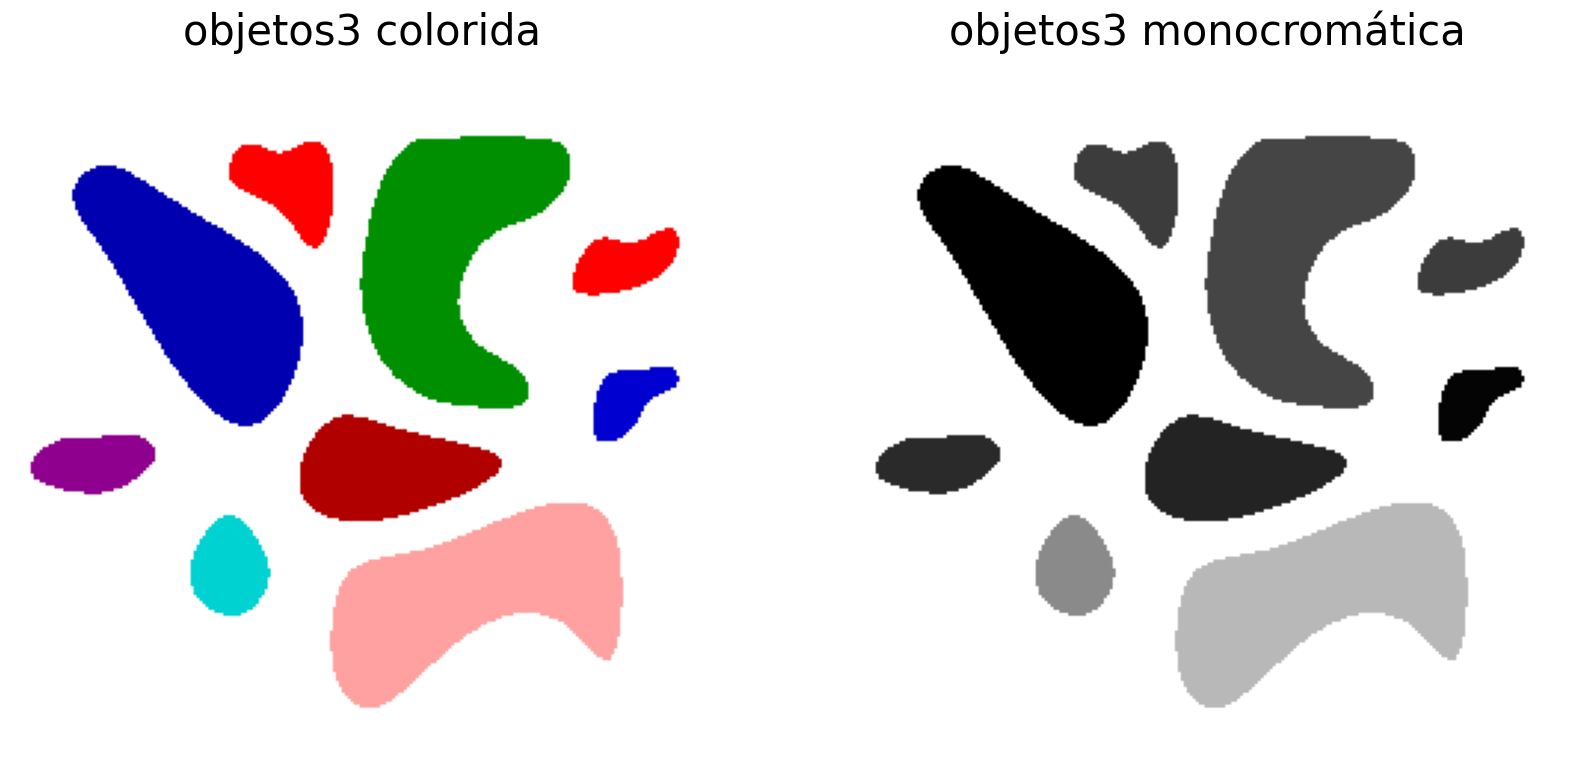

In [3]:
for gray_img, rgb_img, image_name in zip(gray_images, rgb_images, image_files_path):
    # Manipulação da string para se obter o nome do arquivo de imagem
    img_name = image_name.split("/")[-1].split(".")[0]

    print("Nome da imagem de entrada : {}".format(img_name))
    print("Dimensão da imagem monocromática : {}".format(gray_img.shape))
    print("Dimensão da imagem rgb : {}".format(rgb_img.shape))

    plot_figures_in_line(rgb_img, gray_img, title1="{} colorida".format(img_name),
                         title2="{} monocromática".format(img_name),
                         save_dir="ResultadoImagens/ConversaoCores/",
                         save_fig="{}Convertida.png".format(img_name),
                         second_cmap="gray",
                         figsize=(20, 20),
                         fontsize_title=30)

## Parte 2 : Detecção de bordas em imagens
https://scikit-image.org/docs/stable/auto_examples/edges/plot_canny.html
https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_metrics.html#sphx-glr-auto-examples-segmentation-plot-metrics-py
https://scikit-image.org/docs/stable/auto_examples/applications/plot_coins_segmentation.html

TODO : Eu preciso achar um melhor colormap para mostrar apenas o contorno dos objetos

Tem  uma lista de color maps neste link : https://matplotlib.org/stable/tutorials/colors/colormaps.html

Nome da imagem de entrada : objetos1
Dimensão da imagem monocromática : (327, 563)


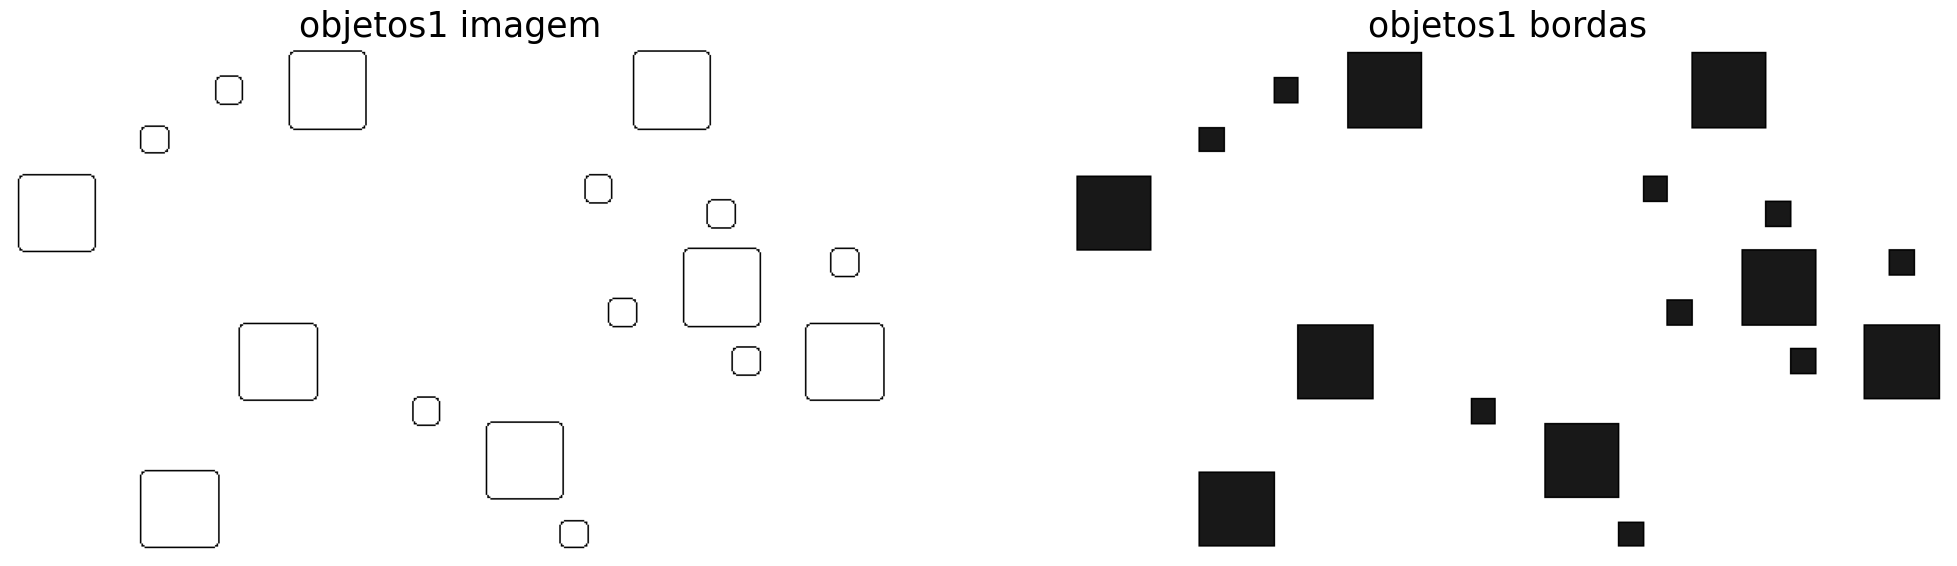

Nome da imagem de entrada : objetos2
Dimensão da imagem monocromática : (343, 563)


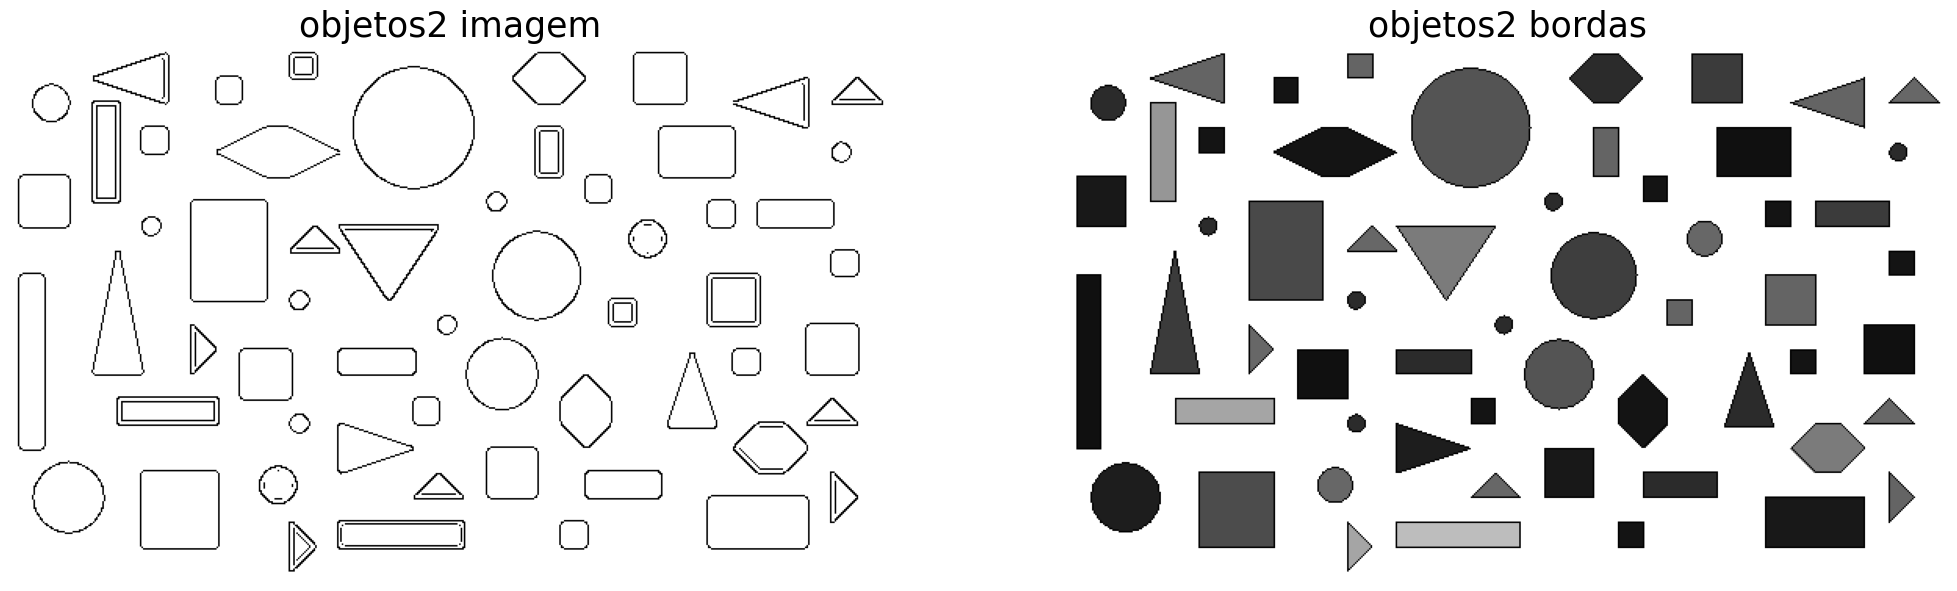

Nome da imagem de entrada : objetos3
Dimensão da imagem monocromática : (238, 238)


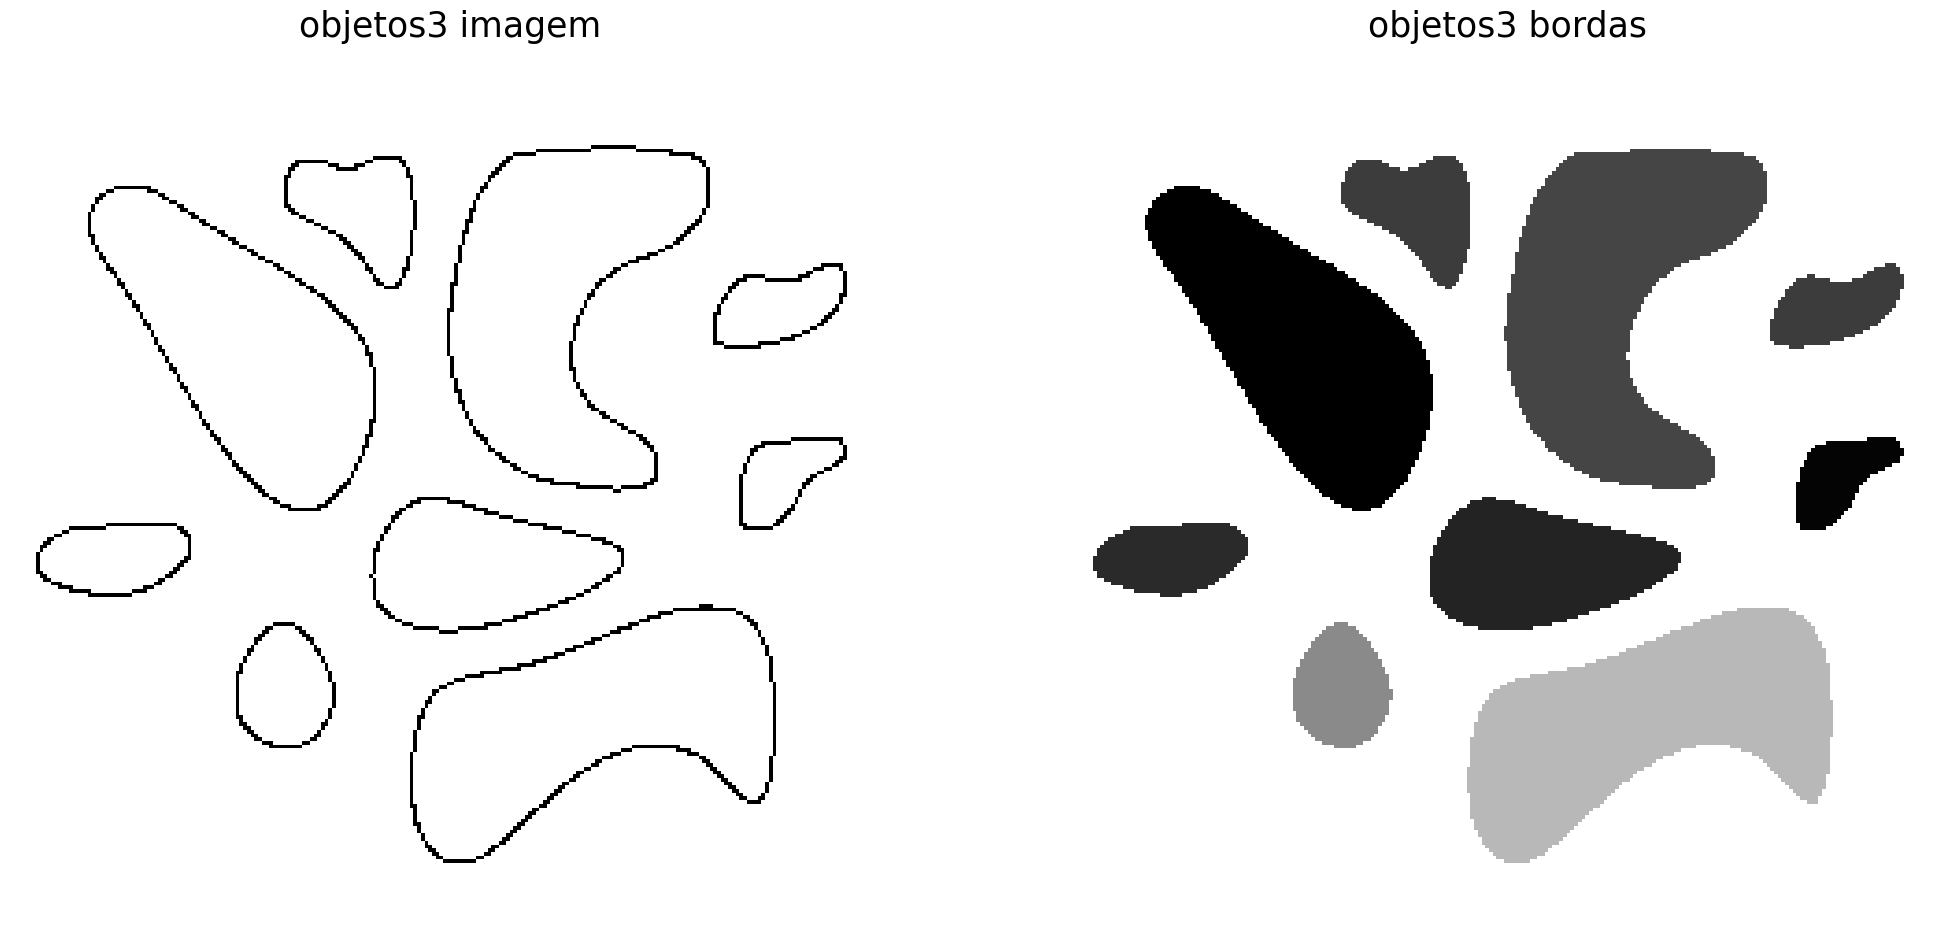

In [4]:
from skimage.feature import canny

for gray_img, image_name in zip(gray_images, image_files_path):
    # Manipulação da string para se obter o nome do arquivo de imagem
    img_name = image_name.split("/")[-1].split(".")[0]

    print("Nome da imagem de entrada : {}".format(img_name))
    print("Dimensão da imagem monocromática : {}".format(gray_img.shape))

    # Subtraindo por 1 para deixar o fundo branco e as bordas dos objetos com preto
    image_edges = 1 - canny(gray_img).astype(np.uint8)

    plot_figures_in_line(image_edges, gray_img, title1="{} imagem".format(img_name),
                         title2="{} bordas".format(img_name),
                         save_dir="ResultadoImagens/Contorno/",
                         save_fig="{}Contorno.png".format(img_name),
                         first_cmap="gray",
                         second_cmap="gray",
                         figsize=(25, 25),
                         fontsize_title=25)

## Parte 3 : Extração de propriedades dos objetos.
https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops

label_img max : 17
================================================== objetos1 ==================================================
Número de regiões : 17

================================================== objetos1 ==================================================
Número de regiões : 17

------------------------- região 0 -------------------------
área : 2162
perímetro : 182.0
excentricidade : 0.20523051726629585
solidez : 1.0
coordenadas do centroid : (x = 202, y = 29)
------------------------------------------------------------

------------------------- região 1 -------------------------
área : 2162
perímetro : 182.0
excentricidade : 0.20523051726629585
solidez : 1.0
coordenadas do centroid : (x = 422, y = 29)
------------------------------------------------------------

------------------------- região 2 -------------------------
área : 210
perímetro : 54.0
excentricidade : 0.35981145856446234
solidez : 1.0
coordenadas do centroid : (x = 139, y = 29)
-------------------------------

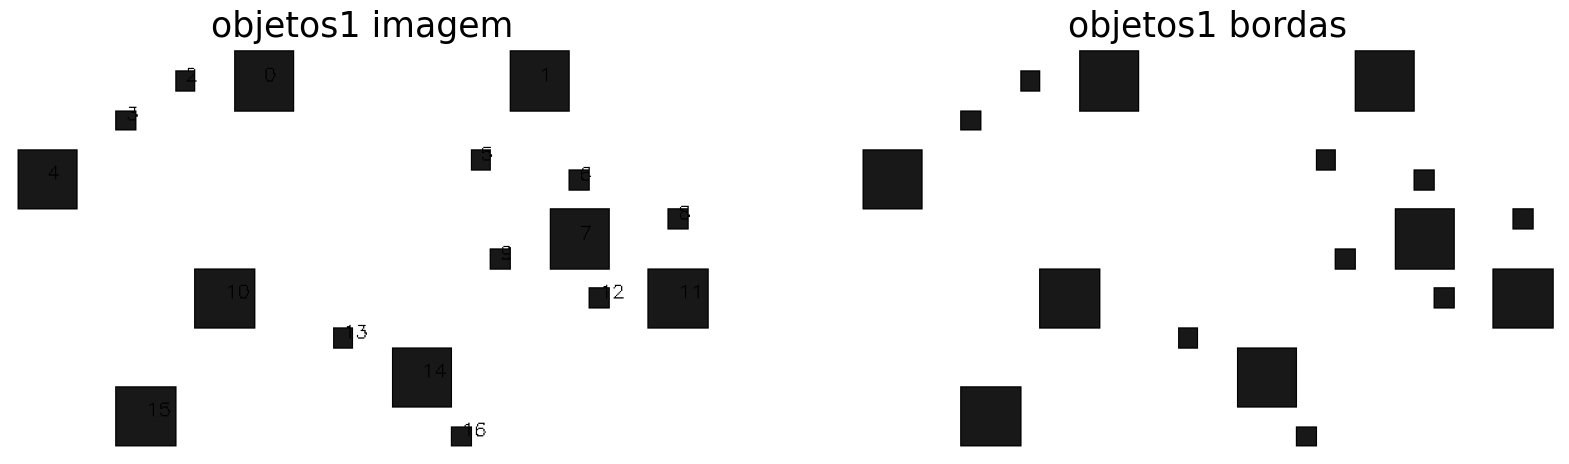


label_img max : 58
================================================== objetos2 ==================================================
Número de regiões : 58

================================================== objetos2 ==================================================
Número de regiões : 58

------------------------- região 0 -------------------------
área : 690
perímetro : 127.18376618407356
excentricidade : 0.8155647091831716
solidez : 0.9610027855153204
coordenadas do centroid : (x = 84, y = 21)
------------------------------------------------------------

------------------------- região 1 -------------------------
área : 210
perímetro : 54.0
excentricidade : 0.35981145856446234
solidez : 1.0
coordenadas do centroid : (x = 187, y = 13)
------------------------------------------------------------

------------------------- região 2 -------------------------
área : 930
perímetro : 113.19595949289334
excentricidade : 0.6509959843025376
solidez : 1.0
coordenadas do centroid : (x = 344, y 

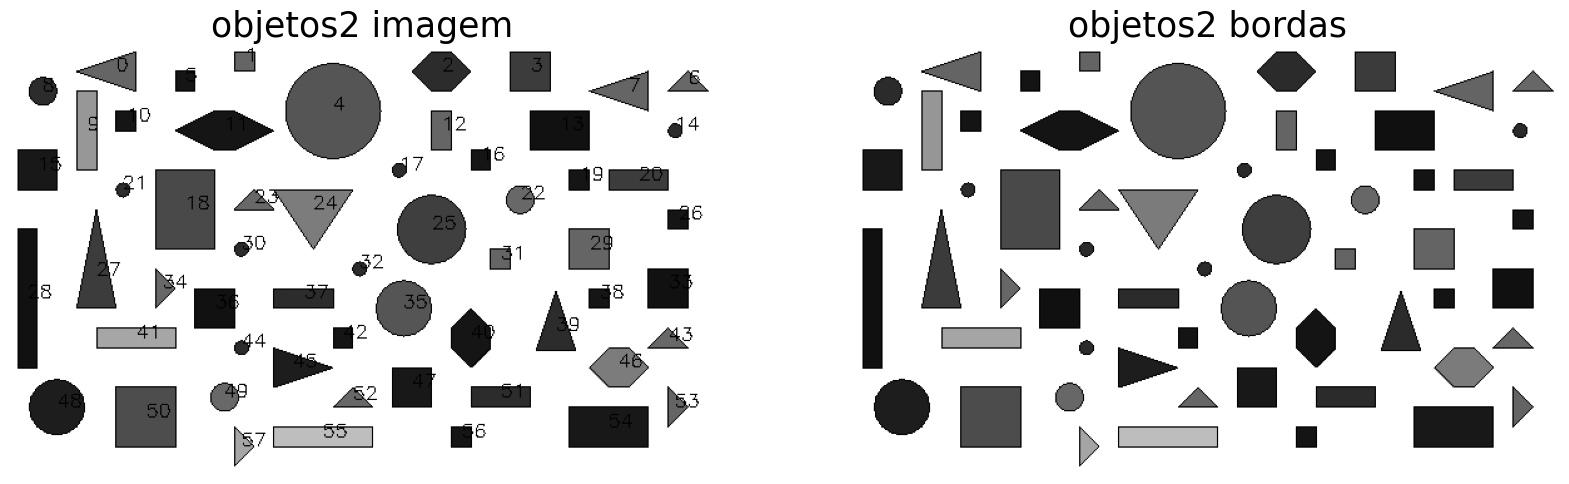


label_img max : 9
================================================== objetos3 ==================================================
Número de regiões : 9

================================================== objetos3 ==================================================
Número de regiões : 9

------------------------- região 0 -------------------------
área : 3969
perímetro : 313.7645019878171
excentricidade : 0.8163620640925742
solidez : 0.7466139954853274
coordenadas do centroid : (x = 147, y = 68)
------------------------------------------------------------

------------------------- região 1 -------------------------
área : 791
perímetro : 119.9827560572969
excentricidade : 0.7411034746078128
solidez : 0.8958097395243488
coordenadas do centroid : (x = 94, y = 43)
------------------------------------------------------------

------------------------- região 2 -------------------------
área : 3584
perímetro : 259.4629867976521
excentricidade : 0.8980731711879257
solidez : 0.9755035383777899

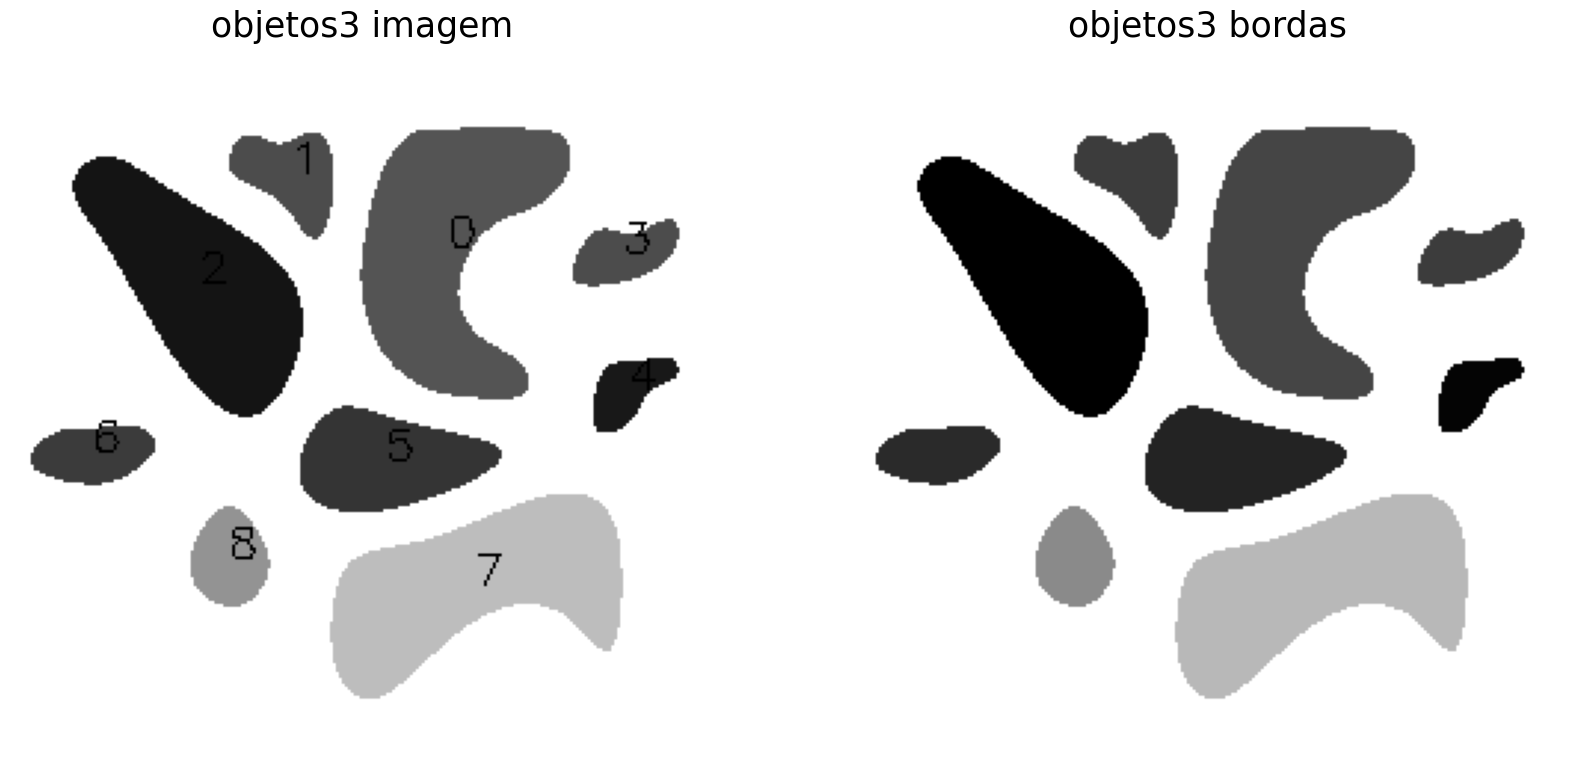

In [5]:
def place_text_to_objects(gray_img: np.ndarray, img_name: str, color: tuple[int, int, int] = (0, 0, 0),
                          thickness: int = 1,
                          fig_size: tuple[int, int] = (10, 10),
                          move_centroid: tuple[float, float] = (0.0, 0.0)) -> tuple[np.ndarray, list[int]]:
    """

    Notes:
        Vou olhar aqui depois para  visualizar melhor os dados
        https://stackoverflow.com/questions/27699999/issues-with-the-labels-in-image-in-matplotlib

    Args:
        gray_img:
        img_name:
        color:
        thickness:
        fig_size:
        move_centroid:

    Returns:

    """

    text_to_print = 50 * "=" + " {} ".format(img_name) + 50 * "="

    # extraindo as informações dos objetos pertencentes na imagem
    df_info_objs, _ = extract_image_info(gray_img)
    img_with_text = gray_img.copy()
    area_list_val = []

    # para esta parte, é extraido todas as característias dos objetos pertencentes da imagem
    print(text_to_print)
    print("Número de regiões : {}\n".format(len(df_info_objs)))

    # para esta parte, é extraido todas as característias dos objetos pertencentes da imagem
    print(text_to_print)
    print("Número de regiões : {}\n".format(len(df_info_objs)))
    for i in range(0, len(df_info_objs)):
        region_text = 25 * "-" + " região {} ".format(i) + 25 * "-"
        print(region_text)

        print("área : {}".format(df_info_objs["area"][i]))
        area_list_val.append(df_info_objs["area"][i])
        print("perímetro : {}".format(df_info_objs["perimeter"][i]))
        print("excentricidade : {}".format(df_info_objs["eccentricity"][i]))
        print("solidez : {}".format(df_info_objs["solidity"][i]))
        centroid_coord = (
            int(df_info_objs["centroid-1"][i] + move_centroid[0]),
            int(df_info_objs["centroid-0"][i] + move_centroid[1]))

        print("coordenadas do centroid : (x = {}, y = {})".format(centroid_coord[0], centroid_coord[1]))

        print(len(region_text) * "-" + "\n")

        # font
        font = cv2.FONT_HERSHEY_SIMPLEX

        font_scale = 0.5

        img_with_text = cv2.putText(img_with_text.astype(np.int32), "{}".format(i), centroid_coord, font,
                                    font_scale, color, thickness, cv2.LINE_AA)

    plot_figures_in_line(img_with_text, gray_img, title1="{} imagem".format(img_name),
                         title2="{} bordas".format(img_name),
                         save_dir="ResultadoImagens/Propriedades/",
                         save_fig="{}Label.png".format(img_name),
                         first_cmap="gray",
                         second_cmap="gray",
                         figsize=fig_size,
                         fontsize_title=25)
    print(len(text_to_print) * "=" + "\n")

    return img_with_text, area_list_val


move_values = ((-1.2, -1.2), (-1.2, -1.2), (0.0, 0.0))
area_values_vec = []
for gray_img, image_name, move_value in zip(gray_images, image_files_path, move_values):
    # Manipulação da string para se obter o nome do arquivo de imagem
    img_name = image_name.split("/")[-1].split(".")[0]
    _, object_area = place_text_to_objects(gray_img, img_name, move_value, fig_size=(20, 20))
    area_values_vec.append(object_area)

## Parte 3 : Histograma

[TODO] : Olhar este [_link_](https://realpython.com/python-histograms/) com mais calma depois
tem esse tb [esse](https://datatofish.com/plot-histogram-python/) que parece uma boa ideia

ah : 1684


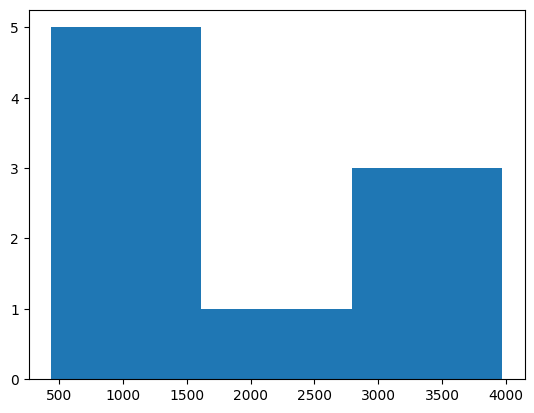

[5. 1. 3.] [ 438. 1615. 2792. 3969.]


In [6]:
object_area = area_values_vec[2]

for area in object_area:
    if (area >= 1500 and area < 3000):
        print("ah : {}".format(area))

n, bins, patches = plt.hist(object_area, bins=3, rwidth=2.0)
plt.show()

print(n, bins)